In [1]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-92xl17_l
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-92xl17_l
  Resolved https://github.com/facebookresearch/detectron2.git to commit 017abbfa5f2c2a2afa045200c2af9ccf2fc6227f
  Preparing metadata (setup.py) ... done


In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/bin/bash: line 1: nvcc: command not found
torch:  2.0 ; cuda:  cu117
detectron2: 0.6


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
import json

def is_coco_format(file_path):
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)

        # Check if the main keys are present
        if not all(key in data for key in ["images", "annotations", "categories"]):
            return False

        # Check if 'images' has the required keys
        for image in data["images"]:
            if not all(key in image for key in ["height", "width", "id", "file_name"]):
                return False

        # Check if 'annotations' has the required keys
        for annotation in data["annotations"]:
            if not all(key in annotation for key in ["iscrowd", "image_id", "bbox", "category_id", "id", "area"]):
                return False

        # Check if 'categories' has the required keys
        for category in data["categories"]:
            if not all(key in category for key in ["id", "name"]):
                return False

        return True
    except Exception as e:
        print(f"An error occurred: {e}")
        return False

In [5]:
file_path = '/home/hous/Desktop/LLAVA/CarDD_release/CarDD_COCO/annotations/instances_train2017.json'
result = is_coco_format(file_path)
print(f"Is COCO Format: {result}")

Is COCO Format: True


In [6]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/home/hous/Desktop/LLAVA/CarDD_release/CarDD_COCO/annotations/instances_train2017.json", "/home/hous/Desktop/LLAVA/CarDD_release/CarDD_COCO/train2017")

In [7]:
register_coco_instances("my_dataset_val", {}, "/home/hous/Desktop/LLAVA/CarDD_release/CarDD_COCO/annotations/instances_val2017.json", "/home/hous/Desktop/LLAVA/CarDD_release/CarDD_COCO/val2017")

In [8]:
from detectron2.data import DatasetCatalog

def is_dataset_registered(name):
    return name in DatasetCatalog.list()

dataset_name = "my_dataset_train"
if is_dataset_registered(dataset_name):
    print(f"The dataset '{dataset_name}' is registered.")
else:
    print(f"The dataset '{dataset_name}' is not registered.")

The dataset 'my_dataset_train' is registered.


[11/23 09:48:07 d2.data.datasets.coco]: Loaded 2816 images in COCO format from /home/hous/Desktop/LLAVA/CarDD_release/CarDD_COCO/annotations/instances_train2017.json


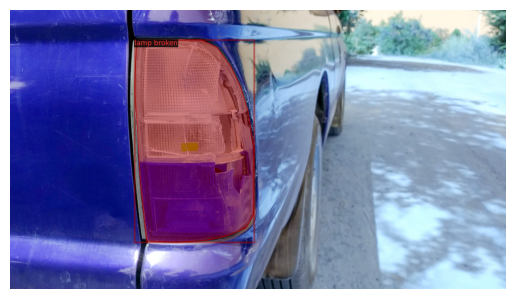

In [9]:
import random
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
import cv2
import matplotlib.pyplot as plt

# Load the dataset and retrieve metadata
dataset_dicts = DatasetCatalog.get(dataset_name)
dataset_metadata = MetadataCatalog.get(dataset_name)

# Pick a random sample from the dataset
sample = random.choice(dataset_dicts)

# Read the image
img = cv2.imread(sample["file_name"])

# Create a Visualizer object
visualizer = Visualizer(img[:, :, ::-1], metadata=dataset_metadata)

# Visualize the annotations
vis_output = visualizer.draw_dataset_dict(sample)

# Display the image using Matplotlib
plt.imshow(vis_output.get_image()[:, :, ::-1])
plt.axis("off")
plt.show()

In [10]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [11]:
from detectron2.data import DatasetMapper, build_detection_train_loader
from detectron2.data import transforms as T
import copy
import torch
from detectron2.data import detection_utils as utils

In [12]:
def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")

    transform_list = [
        T.RandomRotation(angle=[90, 180, 270]),  # Simple rotation
        T.RandomContrast(0.8, 1.2),             # Random contrast
        T.RandomBrightness(0.8, 1.2),           # Random brightness
    ]

    image, transforms = T.apply_transform_gens(transform_list, image)

    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict


In [13]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
import os

In [14]:
def custom_train_loader(cfg):
    return build_detection_train_loader(cfg, mapper=custom_mapper)

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return custom_train_loader(cfg)

In [15]:
# Define hyperparameters
batch_size = 4  # Example batch size

# Configure the model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = batch_size
cfg.SOLVER.BASE_LR = 0.00025  # Starting learning rate
cfg.TEST.EVAL_PERIOD = 500
cfg.SOLVER.MAX_ITER = 5000
cfg.SOLVER.STEPS = (3000, 4000)  # Points to decrease the learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 7

# Learning rate scheduler configuration
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.WARMUP_METHOD = "linear"
cfg.SOLVER.GAMMA = 0.1  # Learning rate reduction factor
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"
cfg.SOLVER.WEIGHT_DECAY = 0.001  # Regularization - weight decay

# Set up output directory
output_dir = "/home/hous/Desktop/LLAVA/output"
os.makedirs(output_dir, exist_ok=True)
cfg.OUTPUT_DIR = output_dir

# Initialize the trainer and start training
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[11/23 09:48:08 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (28, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (28,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (7, 256, 1, 1) 

[11/23 09:48:09 d2.engine.train_loop]: Starting training from iteration 0
ERROR [11/23 09:48:10 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/home/hous/anaconda3/envs/torch/lib/python3.10/site-packages/detectron2/engine/train_loop.py", line 155, in train
    self.run_step()
  File "/home/hous/anaconda3/envs/torch/lib/python3.10/site-packages/detectron2/engine/defaults.py", line 494, in run_step
    self._trainer.run_step()
  File "/home/hous/anaconda3/envs/torch/lib/python3.10/site-packages/detectron2/engine/train_loop.py", line 310, in run_step
    loss_dict = self.model(data)
  File "/home/hous/anaconda3/envs/torch/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/hous/anaconda3/envs/torch/lib/python3.10/site-packages/detectron2/modeling/meta_arch/rcnn.py", line 158, in forward
    features = self.backbone(images.tensor)
  File "/home/hous/anaconda3/

OutOfMemoryError: CUDA out of memory. Tried to allocate 352.00 MiB (GPU 0; 3.81 GiB total capacity; 3.49 GiB already allocated; 116.06 MiB free; 3.62 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF